<a href="https://colab.research.google.com/github/Ahmad-abdulrahim/IT-Jobpost-Classification-Job-Title-Similarity/blob/Development/Job_Classifier_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import necessary libraries**

In [1]:
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical computations
import re           # For regular expressions
import nltk         # Natural Language Toolkit
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords   # Stopwords
from nltk.tokenize import word_tokenize  # Tokenization
from nltk.stem import WordNetLemmatizer  # Lemmatization
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Job posts dataset exploration

## Dataset information

In [2]:
from google.colab import files
files.upload()  # Upload Kaggle API token (kaggle.json)
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!kaggle datasets download -d udacity/armenian-online-job-postings

Saving kaggle.json to kaggle.json
 36% 5.00M/14.0M [00:00<00:00, 36.6MB/s]
100% 14.0M/14.0M [00:00<00:00, 75.6MB/s]


In [3]:
!unzip armenian-online-job-postings.zip

Archive:  armenian-online-job-postings.zip
  inflating: example-job-posting.jpg  
  inflating: features.txt            
  inflating: online-job-postings.csv  


In [4]:
jobs = pd.read_csv("online-job-postings.csv")
jobs.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\r\...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\r\...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\r\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False
3,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\r\n...,NaN,23 January 2004\r\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\r\nJOB TITLE: Software...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\r\n- CV; \...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [5]:
jobs.columns

Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT'],
      dtype='object')

In [6]:
jobs.shape

(19001, 24)

In [7]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           19001 non-null  object
 1   date              19001 non-null  object
 2   Title             18973 non-null  object
 3   Company           18994 non-null  object
 4   AnnouncementCode  1208 non-null   object
 5   Term              7676 non-null   object
 6   Eligibility       4930 non-null   object
 7   Audience          640 non-null    object
 8   StartDate         9675 non-null   object
 9   Duration          10798 non-null  object
 10  Location          18969 non-null  object
 11  JobDescription    15109 non-null  object
 12  JobRequirment     16479 non-null  object
 13  RequiredQual      18517 non-null  object
 14  Salary            9622 non-null   object
 15  ApplicationP      18941 non-null  object
 16  OpeningDate       18295 non-null  object
 17  Deadline    

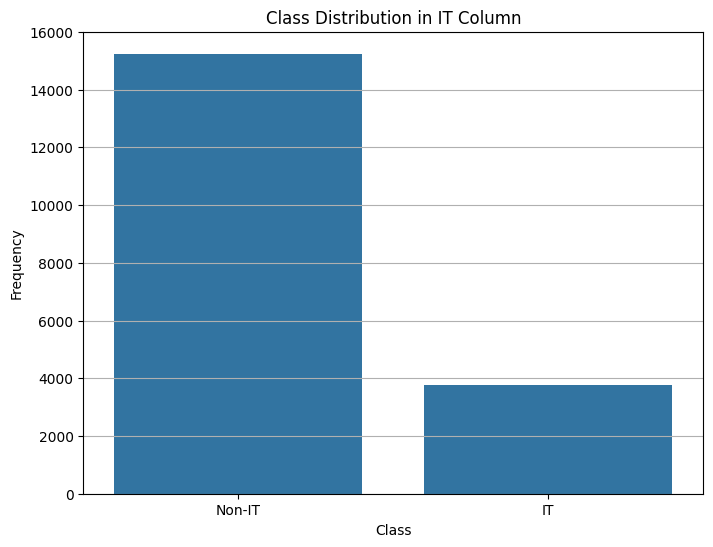

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))  # Setting the figure size
sns.countplot(x='IT', data=jobs)  # Plotting the count of each class in the 'IT' column

plt.title('Class Distribution in IT Column')  # Title of the plot
plt.xlabel('Class')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.xticks([0, 1], ['Non-IT', 'IT'])  # Customizing x-axis ticks for clarity
plt.grid(axis='y')  # Adding a grid for better readability

plt.show()

## Dataset Cleaning

In [10]:
#removing duplicate jobposts based on title and post
jobs = jobs.drop_duplicates(['jobpost', 'Title'])

In [12]:
#removing records with null titles
jobs = jobs[jobs.Title.notna()]

In [13]:
jobs.shape

(18865, 24)

In [14]:
# Remove leading and trailing spaces from column names
jobs.columns = jobs.columns.str.strip()
# Rename specific columns for clarity and consistency
jobs.rename(columns={'date': 'Date', 'jobpost': 'Jobpost', 'RequiredQual': 'RequiredQualifications', 'JobRequirment': 'JobRequirement'}, inplace=True)

<ipython-input-14-2bc330435945>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs.rename(columns={'date': 'Date', 'jobpost': 'Jobpost', 'RequiredQual': 'RequiredQualifications', 'JobRequirment': 'JobRequirement'}, inplace=True)


In [15]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18865 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Jobpost                 18865 non-null  object
 1   Date                    18865 non-null  object
 2   Title                   18865 non-null  object
 3   Company                 18865 non-null  object
 4   AnnouncementCode        1202 non-null   object
 5   Term                    7650 non-null   object
 6   Eligibility             4869 non-null   object
 7   Audience                631 non-null    object
 8   StartDate               9638 non-null   object
 9   Duration                10752 non-null  object
 10  Location                18840 non-null  object
 11  JobDescription          15040 non-null  object
 12  JobRequirement          16409 non-null  object
 13  RequiredQualifications  18437 non-null  object
 14  Salary                  9582 non-null   object
 15  Ap

In [16]:
# Convert all column values to string type except for the 'IT' column, preserving NaN values
for col in jobs.columns:
    if col != 'IT':  # Skip the "IT" column
        jobs[col] = jobs[col].apply(lambda x: x if pd.isna(x) else str(x))

<ipython-input-16-f5e564a1a254>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs[col] = jobs[col].apply(lambda x: x if pd.isna(x) else str(x))


In [17]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18865 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Jobpost                 18865 non-null  object
 1   Date                    18865 non-null  object
 2   Title                   18865 non-null  object
 3   Company                 18865 non-null  object
 4   AnnouncementCode        1202 non-null   object
 5   Term                    7650 non-null   object
 6   Eligibility             4869 non-null   object
 7   Audience                631 non-null    object
 8   StartDate               9638 non-null   object
 9   Duration                10752 non-null  object
 10  Location                18840 non-null  object
 11  JobDescription          15040 non-null  object
 12  JobRequirement          16409 non-null  object
 13  RequiredQualifications  18437 non-null  object
 14  Salary                  9582 non-null   object
 15  Ap

# Exploratory Data Analysis (EDA)


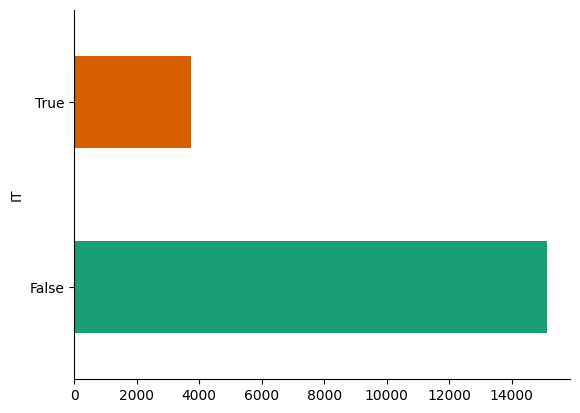

In [18]:
# Plot horizontal bar chart of the number of records for each 'IT' category
from matplotlib import pyplot as plt
import seaborn as sns
jobs.groupby('IT').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))  # Group by 'IT', count, and plot
plt.gca().spines[['top', 'right',]].set_visible(False)  # Hide top and right spines for aesthetics

## Title analysis

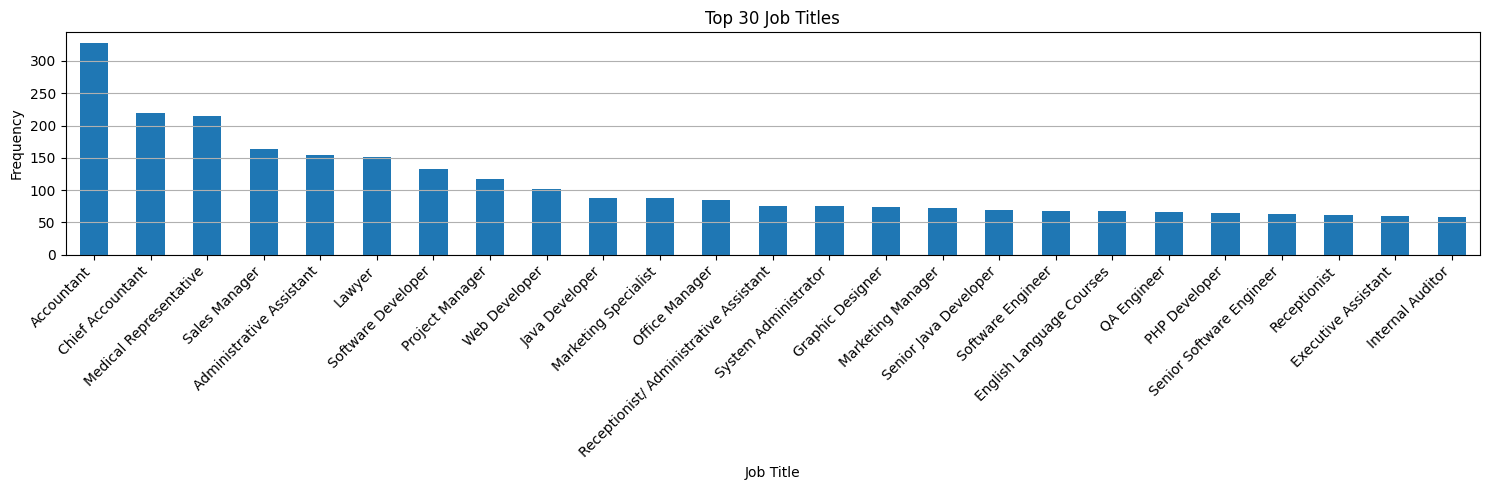

In [35]:
top_30_job_titles = jobs['Title'].value_counts().nlargest(30)

# Plotting the top 30 job titles
plt.figure(figsize=(15, 5))
top_25_job_titles.plot(kind='bar')
plt.title('Top 30 Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate the job titles on x-axis for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.grid(axis='y')
plt.show()

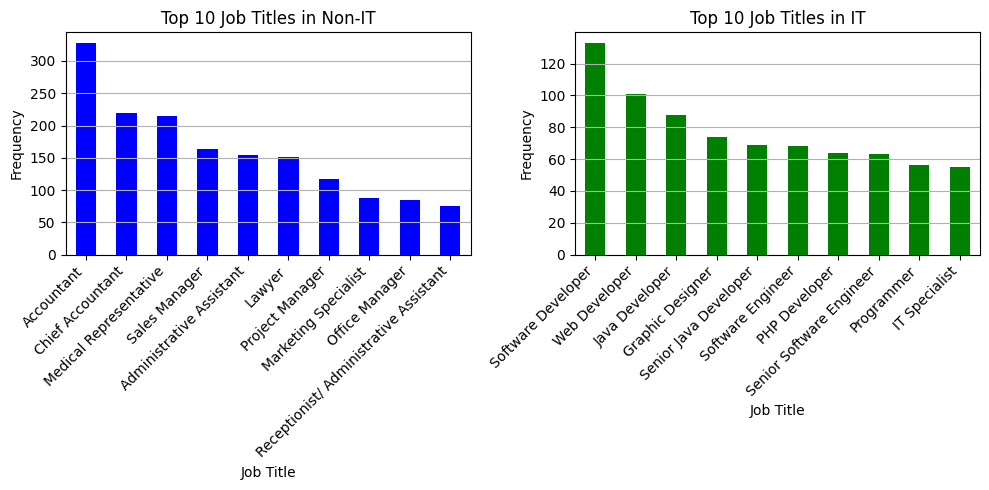

In [43]:
non_it_jobs = jobs[jobs['IT'] == 0]['Title'].value_counts().head(10)
it_jobs = jobs[jobs['IT'] == 1]['Title'].value_counts().head(10)

plt.figure(figsize=(10, 5))

# First subplot for non-IT jobs
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
non_it_jobs.plot(kind='bar', color='blue')
plt.title('Top 10 Job Titles in Non-IT')
plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y")

# Second subplot for IT jobs
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
it_jobs.plot(kind='bar', color='green')
plt.title('Top 10 Job Titles in IT')
plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [44]:
# Load the small English model from spaCy with default pipeline components for basic text processing
nlp = spacy.load("en_core_web_sm")

In [75]:
def preprocess_text_spacy(text):
    """
    Advanced text preprocessing using spaCy.
    """
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.strip().lower()  # Strip whitespace and convert to lowercase
    text = re.sub(r'http\S+', '', text) # Remove Url from text
    doc = nlp(text)  # Process text with spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]  # Lemmatize, remove stopwords and punctuation
    return " ".join(tokens)  # Join tokens into a string

In [21]:
title = jobs.Title.apply(lambda x : preprocess_text_spacy(x))  # Apply preprocessing function to 'Title' column
title.head()  # Display the first 5 processed titles

0                              chief financial officer
1    fulltime community connection intern pay inter...
2                                  country coordinator
3                                       bcc specialist
4                                   software developer
Name: Title, dtype: object

To gain insight into the most sought-after jobs in Armenia, we can analyze job titles using a technique that constructs a document-term matrix (DTM) based on bi-grams or tri-grams. A bi-gram or tri-gram approach breaks down the job titles into pairs or triplets of consecutive words, respectively. By creating this matrix, we can identify which combinations of words (tokens) appear most frequently within the job titles. The most frequently occurring bi-gram or tri-gram can be interpreted as an indicator of the job roles that are currently in highest demand.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer for tokenization, using unigrams
count_vect = CountVectorizer(ngram_range=(1,1))
token = count_vect.fit_transform(title)  # Fit and transform the 'title' series to tokens

In [23]:
print('Total number of tokens/words in all the job titles - ',
      len(count_vect.get_feature_names_out()))

Total number of tokens/words in all the job titles -  2858


In [24]:
title_df =  pd.DataFrame(token.toarray(), columns=count_vect.get_feature_names_out())
title_df.tail()

,aaca,abap,abatement,abattoir,abkhazia,abovyan,abuse,ac,academy,acca,...,yoga,young,youth,zang,zend,zonal,zone,zooplankton,zvartnot,zvartnots
18860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#count the occurence of each token in entire corpus
title_count_df = title_df.apply(lambda x : x.sum())

In [26]:
title_count_df = pd.DataFrame(title_count_df).reset_index()

In [27]:
title_count_df.columns = ['Word', 'Count']

In [28]:
top_title = title_count_df.sort_values(by= 'Count', ascending=False)
top_title[:15]

,Word,Count
1551,manager,2587
2411,specialist,2067
716,developer,1943
868,engineer,1603
2325,senior,1490
208,assistant,1234
2390,software,1099
2260,sale,853
15,accountant,779
704,department,742


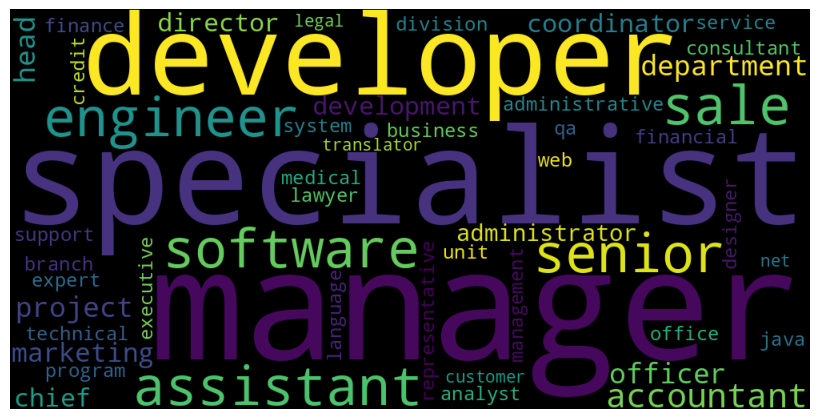

In [29]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(top_title[:50].Word))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

A dispersion plot can be utilized to track the evolution of job roles over time. This involves extracting key topics from job postings and then visualizing their frequency and distribution across different time periods. Essentially, by identifying and plotting these significant themes, we can observe trends and shifts in job demands over the years, providing insights into how certain job roles emerge, evolve, or decline.

## Importing Jobpost pickle file

In [81]:
import gzip
import pickle

# Load the compressed pickle file
with gzip.open('processed_jobpost.pkl.gz', 'rb') as f:
    loaded_data = pickle.load(f)

# Extract the DataFrame from the loaded data
jobs_processed = loaded_data['jobs']

###Preprocessing job post column

In [76]:
jobpost = jobs.Jobpost.apply(lambda x : preprocess_text_spacy(x))
jobpost.head(10)

0    ameria investment consult company job title ch...
1    international research exchange board irex tit...
2    caucasus environmental ngo network cenn job ti...
3    manoff group job title bcc specialist position...
4    yerevan brandy company job title software deve...
5    boutique appollo job title saleswoman position...
6    osi assistance foundation armenian branch offi...
7    international research exchange board irex tit...
8    yerevan brandy company job title assistant man...
9    american embassy yerevan announcement number j...
Name: Jobpost, dtype: object

In [77]:
title

0                                  chief financial officer
1        fulltime community connection intern pay inter...
2                                      country coordinator
3                                           bcc specialist
4                                       software developer
                               ...                        
18996                       senior creative ux ui designer
18997                         category development manager
18998                        operational marketing manager
18999                          head online sale department
19000                              lawyer legal department
Name: Title, Length: 18865, dtype: object

In [78]:
jobpost_preprocessed = pd.DataFrame({'Jobpost':jobpost,'Title':title})

In [79]:
jobpost_preprocessed.head(5)

,Jobpost,Title
0,ameria investment consult company job title ch...,chief financial officer
1,international research exchange board irex tit...,fulltime community connection intern pay inter...
2,caucasus environmental ngo network cenn job ti...,country coordinator
3,manoff group job title bcc specialist position...,bcc specialist
4,yerevan brandy company job title software deve...,software developer


In [80]:
import gzip
import pickle

# Save the processed jobpost df and selected columns to a compressed pickle file
selected_columns = ['Jobpost', 'Title']

processed_data = {
    'jobs': jobpost_preprocessed[selected_columns]
}

with gzip.open('processed_jobpost.pkl.gz', 'wb') as f:
    pickle.dump(processed_data, f)

##Job post Analysis

In [82]:
jobs_processed.head(5)

,Jobpost,Title
0,ameria investment consult company job title ch...,chief financial officer
1,international research exchange board irex tit...,fulltime community connection intern pay inter...
2,caucasus environmental ngo network cenn job ti...,country coordinator
3,manoff group job title bcc specialist position...,bcc specialist
4,yerevan brandy company job title software deve...,software developer


In [83]:
jobs_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18865 entries, 0 to 19000
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Jobpost  18865 non-null  object
 1   Title    18865 non-null  object
dtypes: object(2)
memory usage: 442.1+ KB


In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer with specific conditions and apply it to 'jobpost'
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=0.05, max_df=0.95)
token_jobpost = tfidf.fit_transform(jobpost_preprocessed['Jobpost'])  # Fit and transform 'jobpost' to TF-IDF features
vocab = tfidf.get_feature_names_out()  # Extract the vocabulary of terms found in the documents

In [85]:
jobpost_token = pd.DataFrame(token_jobpost.toarray(), columns=tfidf.get_feature_names_out())
jobpost_token.head()

,ability,ability work,access,accord,accordance,account,accountant,accounting,accuracy,accurate,...,write communication,write speak,writing,year,year experience,year professional,year relevant,year work,yerevan,yerevan armenia
0,0.042334,0.019176,0.0,0.0,0.0,0.097952,0.0,0.23532,0.0,0.0,...,0.0,0.00000,0.033011,0.013172,0.000000,0.0,0.000000,0.0,0.009992,0.010207
1,0.034500,0.046881,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.146567,0.049907
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.000000,0.035537,0.000000,0.0,0.096479,0.0,0.026956,0.027536
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.04769,0.000000,0.016988,0.031362,0.0,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.000000,0.057678,0.106481,0.0,0.000000,0.0,0.131251,0.044692


In [86]:
column_names = jobpost_token.columns.tolist()
print(column_names)

['ability', 'ability work', 'access', 'accord', 'accordance', 'account', 'accountant', 'accounting', 'accuracy', 'accurate', 'achieve', 'act', 'action', 'activity', 'additional', 'additional note', 'address', 'administration', 'administrative', 'advanced', 'advantage', 'agency', 'agreement', 'aim', 'amd', 'analysis', 'analytical', 'analytical skill', 'analyze', 'andor', 'announcement code', 'announcement download', 'annual', 'applicant', 'application form', 'apply', 'apply position', 'apply subject', 'approach', 'appropriate', 'april', 'april application', 'april company', 'area', 'armenia place', 'armenia title', 'armenian', 'armenian english', 'armenian language', 'armenian russian', 'asap', 'asap duration', 'asap location', 'ask', 'aspect', 'assessment', 'asset', 'assign', 'assist', 'assistance', 'assistant', 'attach', 'attachment', 'attachment announcement', 'attachment follow', 'attention', 'attention detail', 'august', 'august application', 'august company', 'authority', 'availab

Latent Dirichlet Allocation (LDA) technique, a type of topic modeling, to analyze and understand the main themes or natures of jobs from tokenized job postings. The goal is to identify clusters of words that represent significant topics within the job posts, which can help in understanding the nature and profiles of jobs.

In [87]:
# Apply LDA to discern significant aspects of job nature and profiles
from sklearn import decomposition

# Initialize LDA model
lda = decomposition.LatentDirichletAllocation(n_components=5, learning_method='online', max_iter=50, random_state=3)
lda.fit_transform(token_jobpost)  # Fit and transform TF-IDF features to LDA
topics = lda.components_  # Extract the components (topics) from the LDA model

In [88]:
topics

array([[2.19845612e+02, 9.04047124e+01, 2.16534468e+01, ...,
        8.37702802e+01, 1.41007194e+02, 1.29749284e+02],
       [1.68878914e+02, 5.87939074e+01, 4.78811327e+01, ...,
        2.38550454e+01, 1.35694147e+02, 8.70316739e+01],
       [2.67784364e+02, 1.68779920e+02, 1.69316750e+01, ...,
        8.83121957e+01, 2.61998408e+02, 2.21854638e+02],
       [9.15730460e+00, 7.57936170e+00, 2.03954371e-01, ...,
        1.34838129e+01, 7.54321656e+00, 8.56659842e+00],
       [1.13534349e+02, 7.16248858e+01, 1.00893458e+01, ...,
        5.25742904e+01, 9.06714536e+01, 6.58592124e+01]])

In [89]:
# Generate summaries for each topic with the top words
n_top_words = 15
topic_summaries = []
for i, topic_dist in enumerate(topics):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]  # Select top words for each topic
    topic_summaries.append(' '.join(topic_words))  # Create summary string

topic_summaries  # Display the topic summaries

['software design development developer experience knowledge web test work team company system engineer software development technology',
 'project program development management international work training support activity ensure office provide experience implementation skill',
 'sale company work customer skill knowledge marketing llc language candidate excellent russian time experience term',
 'accounting financial accountant tax finance chief account report prepare payment statement control legislation transaction budget',
 'bank credit cjsc banking application form form knowledge legal attachment skill candidate work service financial branch']

In [90]:
topic_words_tokens = []
for topic in topic_summaries:
    word_token = nltk.word_tokenize(topic)  # Tokenize each topic summary
    topic_words_tokens.extend(word_token)  # Append tokens to list
print(topic_words_tokens)  # Print the list of tokens from all topic summaries

['software', 'design', 'development', 'developer', 'experience', 'knowledge', 'web', 'test', 'work', 'team', 'company', 'system', 'engineer', 'software', 'development', 'technology', 'project', 'program', 'development', 'management', 'international', 'work', 'training', 'support', 'activity', 'ensure', 'office', 'provide', 'experience', 'implementation', 'skill', 'sale', 'company', 'work', 'customer', 'skill', 'knowledge', 'marketing', 'llc', 'language', 'candidate', 'excellent', 'russian', 'time', 'experience', 'term', 'accounting', 'financial', 'accountant', 'tax', 'finance', 'chief', 'account', 'report', 'prepare', 'payment', 'statement', 'control', 'legislation', 'transaction', 'budget', 'bank', 'credit', 'cjsc', 'banking', 'application', 'form', 'form', 'knowledge', 'legal', 'attachment', 'skill', 'candidate', 'work', 'service', 'financial', 'branch']


In [91]:
vocab = []  # Initialize empty list to store vocabulary

def fn_token(post):
    list_temp = nltk.word_tokenize(post)  # Tokenize the post
    vocab.extend(list_temp)  # Extend the vocab list with tokens

jobpost.apply(lambda x: fn_token(x))  # Apply tokenization function to each job post

0        None
1        None
2        None
3        None
4        None
         ... 
18996    None
18997    None
18998    None
18999    None
19000    None
Name: Jobpost, Length: 18865, dtype: object

In [92]:
full_vocab = []  # Initialize empty list for unique vocabulary

for word in vocab:
    if word not in full_vocab:  # Check if word is not already in full_vocab
        full_vocab.append(word)  # Add unique word to full_vocab

<Figure size 1500x1000 with 0 Axes>

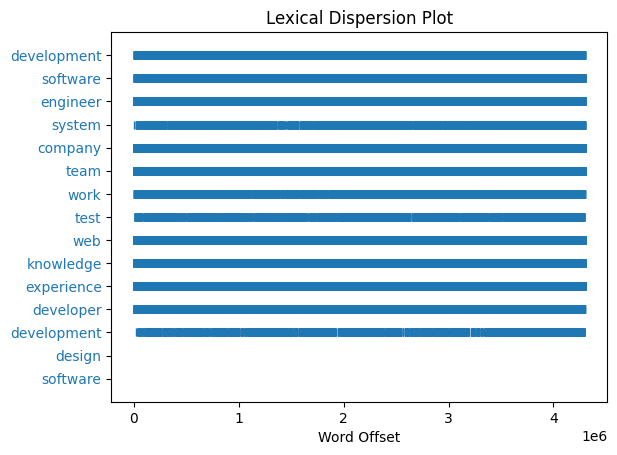

In [94]:
# Visualize the dispersion of the top 15 topic words across the text
from nltk.draw.dispersion import dispersion_plot

plt.figure(figsize=(15, 10))  # Increase figure size to make the plot less cluttered
dispersion_plot(vocab, topic_words_tokens[:15])
plt.show()

# IT Job Classification

In [96]:
jobs.shape

(18865, 24)

In [98]:
jobs_processed.shape

(18865, 2)

In [99]:
jobs_with_labels = pd.concat([jobs_processed, jobs['IT']], axis=1)

In [100]:
jobs_with_labels.head(5)

,Jobpost,Title,IT
0,ameria investment consult company job title ch...,chief financial officer,False
1,international research exchange board irex tit...,fulltime community connection intern pay inter...,False
2,caucasus environmental ngo network cenn job ti...,country coordinator,False
3,manoff group job title bcc specialist position...,bcc specialist,False
4,yerevan brandy company job title software deve...,software developer,True


In [101]:
# Convert boolean values in the 'IT' column to binary integers (0 for False, 1 for True) and store the result in the 'IT' column
jobs_with_labels['IT'] = jobs_with_labels['IT'].apply(lambda x: 0 if x is False else 1)

In [105]:
jobs_with_labels.head(5)

,Jobpost,Title,IT
0,ameria investment consult company job title ch...,chief financial officer,0
1,international research exchange board irex tit...,fulltime community connection intern pay inter...,0
2,caucasus environmental ngo network cenn job ti...,country coordinator,0
3,manoff group job title bcc specialist position...,bcc specialist,0
4,yerevan brandy company job title software deve...,software developer,1


In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [108]:
# Assume 'jobpost' is the column with text data, and 'label' is the target variable
X_train, X_test, y_train, y_test = train_test_split(jobs_with_labels['Jobpost'], jobs_with_labels['IT'], test_size=0.2, random_state=42)

In [110]:
#Tokenization
# Vectorize the job posts with TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df = 0.05, max_df=0.95, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [111]:
# Now resample the training set to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [112]:
from collections import Counter
print('Original class distribution:', Counter(y_train))
print('Resampled class distribution:', Counter(y_train_resampled))

Original class distribution: Counter({0: 12071, 1: 3021})
Resampled class distribution: Counter({0: 12071, 1: 12071})


In [114]:
print(X_train_resampled.shape)
print(X_test_tfidf.shape)
print(y_train_resampled.shape)
print(y_test.shape)

(24142, 750)
(3773, 750)
(24142,)
(3773,)


## Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters for tuning the RandomForestClassifier
param_grid = {'n_estimators': [130, 150, 160, 180, 200],
              'max_features': [13, 15, 17, 19]}

# Instantiate a GridSearchCV object with RandomForestClassifier as the estimator,
# the defined param_grid, 10-fold cross-validation, parallel processing enabled, and verbose output
grid_rf = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid=param_grid,
                       cv=10,
                       n_jobs=-1,
                       verbose=True)

# Fit the GridSearchCV object to the training data (train_x) and target labels (train_y)
grid_rf.fit(X_train_resampled, y_train_resampled)

In [ ]:
print("Best Score: ", grid_rf.best_score_)
print("Best Parameters: ", grid_rf.best_params_)
print("Best Estimator: ", grid_rf.best_estimator_)
# Best parameters max_features: 19, n_estimators:180

In [116]:
#Fit the model
rf_model = RandomForestClassifier(max_features=19, n_estimators=180)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_features=19, n_estimators=180)

In [117]:
rf_train_predict = pd.DataFrame({'actual' : y_train_resampled,
                                 'predicted' : rf_model.predict(X_train_resampled)})
rf_train_predict.head(10)

,actual,predicted
17721,1,1
17617,1,1
8660,0,0
13374,0,0
8743,0,0
4708,1,1
14950,0,0
16561,0,0
10202,0,0
14589,0,0


In [118]:
rf_test_predict = pd.DataFrame({'actual' : y_test,
                                 'predicted' : rf_model.predict(X_test_tfidf)})
rf_test_predict.head(10)

,actual,predicted
17721,1,1
17617,1,1
8660,0,0
13374,0,0
8743,0,0
4708,1,1
14950,0,0
16561,0,0
10202,0,0
14589,0,0


### Random Forest Model Evaluation

In [119]:
# Check accuracy score on train and test
from sklearn import metrics

print('Accuracy Score for train dataset : ' , metrics.accuracy_score(rf_train_predict.actual, rf_train_predict.predicted))
print('Accuracy Score for test dataset : ' , metrics.accuracy_score(rf_test_predict.actual, rf_test_predict.predicted))

Accuracy Score for train dataset :  0.9491121123774185
Accuracy Score for test dataset :  0.9491121123774185


In [120]:
# Check roc_auc score on train and test

print('ROC-AUC Score for train dataset : ' , metrics.roc_auc_score(rf_train_predict.actual, rf_train_predict.predicted))
print('ROC-AUC Score for validation dataset : ' , metrics.roc_auc_score(rf_test_predict.actual, rf_test_predict.predicted))

ROC-AUC Score for train dataset :  0.9161224362615955
ROC-AUC Score for validation dataset :  0.9161224362615955


<Axes: >

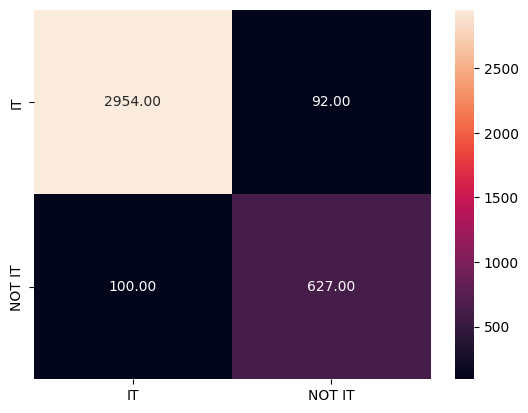

In [121]:
# Create confusion matrix for Test aet

conn_cm_test = metrics.confusion_matrix(rf_test_predict.actual, rf_test_predict.predicted)
sns.heatmap(conn_cm_test, fmt= '.2f', annot=True,  xticklabels=['IT', 'NOT IT'], yticklabels=['IT', 'NOT IT'])

In [122]:
#Create classification report
print(metrics.classification_report(rf_test_predict.actual, rf_test_predict.predicted))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3046
           1       0.87      0.86      0.87       727

    accuracy                           0.95      3773
   macro avg       0.92      0.92      0.92      3773
weighted avg       0.95      0.95      0.95      3773



In [131]:
# Get the feature names
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Get feature importances
importances = rf_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Convert to a DataFrame
feature_rank = pd.DataFrame(columns=['Rank', 'Feature', 'Importance'])

for f in range(X_train_resampled.shape[1]):  # Assuming X_train_resampled is the output from SMOTE
    feature_rank.loc[f] = [f + 1,
                           feature_names[indices[f]],
                           importances[indices[f]]]

In [134]:
# Now 'feature_rank' DataFrame contains the ranks, feature names, and their importance scores
feature_rank.head(10)

,Rank,Feature,Importance
0,1,developer,0.051399
1,2,software,0.041376
2,3,design,0.029799
3,4,software development,0.023195
4,5,sql,0.022665
5,6,technology,0.019548
6,7,computer science,0.018948
7,8,server,0.018070
8,9,development,0.017754
9,10,web,0.016183


In [135]:
feature_rank[10:]

,Rank,Feature,Importance
10,11,experience,0.014794
11,12,java,0.014696
12,13,javascript,0.014489
13,14,programming,0.014186
14,15,armenian,0.014132
...,...,...,...
745,746,main,0.000120
746,747,commitment,0.000117
747,748,correspondence,0.000093
748,749,negotiation skill,0.000089


In [137]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=44fc6f4604e21e5448efee4a910e05e3eb71e826ea1ec00b7c30d291411f40fb
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [144]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

# Create a pipeline that first vectorizes the text and then applies the classifier
pipeline = make_pipeline(tfidf_vectorizer, rf_model)

# Instantiate the explainer
explainer = LimeTextExplainer(class_names=['Non-IT', 'IT'])

# Choose an instance to explain
idx = 0  # Index of the instance in the test set
text_instance = X_test.iloc[idx]

In [146]:
# Correctly using the pipeline with raw text input
print('Document id: %d' % idx)
print('Predicted class =', rf_model.classes_[pipeline.predict([X_test.iloc[idx]]).astype(int)][0])
print('True class: %s' % y_test.iloc[idx])

Document id: 0
Predicted class = 1
True class: 1


In [147]:
# Generate the explanation for the prediction with the correct input
exp = explainer.explain_instance(X_test.iloc[idx], pipeline.predict_proba, num_features=10)
exp.show_in_notebook(text=True)

In [187]:
from joblib import dump
dump(rf_model, "random_forest_model.joblib")
print("Model saved successfully.")

Model saved successfully.


##RNN Model

In [148]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.utils import to_categorical

In [150]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(jobs_with_labels['Jobpost'])
X = tokenizer.texts_to_sequences(jobs_with_labels['Jobpost'])
X = pad_sequences(X, maxlen=100)  # Pad the sequences to a maximum length

In [151]:
y.head(5)

0    0
1    0
2    0
3    0
4    1
Name: IT, dtype: int64

In [157]:
# Convert labels to categorical (one-hot encoding)
y = to_categorical(jobs_with_labels['IT'])

In [158]:
# Split the data (after padding and tokenization)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
# Define the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=100))
rnn_model.add(LSTM(64))
rnn_model.add(Dense(2, activation='softmax'))  # Assuming binary classification ('0' or '1')

In [160]:
# Compile the model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [162]:
# Train the model
history = rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
425/425 [==============================] - 83s 195ms/step - loss: 0.2324 - accuracy: 0.9204 - val_loss: 0.2809 - val_accuracy: 0.9099
Epoch 2/10
425/425 [==============================] - 59s 140ms/step - loss: 0.1952 - accuracy: 0.9348 - val_loss: 0.2688 - val_accuracy: 0.9172
Epoch 3/10
425/425 [==============================] - 54s 127ms/step - loss: 0.1581 - accuracy: 0.9512 - val_loss: 0.2614 - val_accuracy: 0.8987
Epoch 4/10
425/425 [==============================] - 77s 182ms/step - loss: 0.1346 - accuracy: 0.9571 - val_loss: 0.3315 - val_accuracy: 0.9099
Epoch 5/10
425/425 [==============================] - 79s 186ms/step - loss: 0.1156 - accuracy: 0.9621 - val_loss: 0.2965 - val_accuracy: 0.9172
Epoch 6/10
425/425 [==============================] - 52s 122ms/step - loss: 0.1060 - accuracy: 0.9653 - val_loss: 0.3262 - val_accuracy: 0.9093
Epoch 7/10
425/425 [==============================] - 53s 125ms/step - loss: 0.0931 - accuracy: 0.9692 - val_loss: 0.3222 - val_ac

###RNN Evaluation

In [166]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model on test data
rnn_predictions = rnn_model.predict(X_test)
rnn_predicted_classes = (rnn_predictions > 0.5).astype(int)

# Calculate metrics for the test set
rnn_accuracy = accuracy_score(y_test, rnn_predicted_classes)
rnn_precision = precision_score(y_test, rnn_predicted_classes, average='macro')
rnn_recall = recall_score(y_test, rnn_predicted_classes, average='macro')
rnn_f1 = f1_score(y_test, rnn_predicted_classes, average='macro')


print("Test Set Performance:")
print(f"Accuracy: {rnn_accuracy}")
print(f"Precision: {rnn_precision}")
print(f"Recall: {rnn_recall}")
print(f"F1 Score: {rnn_f1}")
print("\n")

# Evaluate the model on train data
rnn_predictions = rnn_model.predict(X_train)
rnn_predicted_classes = (rnn_predictions > 0.5).astype(int)

# Calculate metrics for the train set
rnn_accuracy = accuracy_score(y_train, rnn_predicted_classes)
rnn_precision = precision_score(y_train, rnn_predicted_classes, average='macro')
rnn_recall = recall_score(y_train, rnn_predicted_classes, average='macro')
rnn_f1 = f1_score(y_train, rnn_predicted_classes, average='macro')

print("Train Set Performance:")
print(f"Accuracy: {rnn_accuracy}")
print(f"Precision: {rnn_precision}")
print(f"Recall: {rnn_recall}")
print(f"F1 Score: {rnn_f1}")
print("\n")

118/118 [==============================] - 6s 47ms/step
Test Set Performance:
Accuracy: 0.9175722236946727
Precision: 0.8901675346312024
Recall: 0.8327084204508404
F1 Score: 0.8573062271797257


472/472 [==============================] - 10s 21ms/step
Train Set Performance:
Accuracy: 0.9601775775245163
Precision: 0.9549608848697896
Recall: 0.9183980849706652
F1 Score: 0.9352596893300303




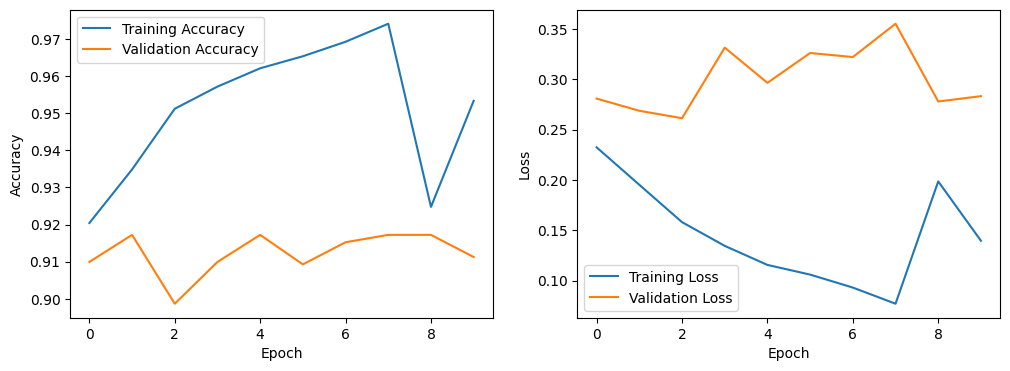

In [167]:
# Plot training and validation accuracy per epoch.
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss per epoch.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

157/157 [==============================] - 5s 30ms/step
[('atmailbox', -0.003113709419265857), ('email', -0.0007972839380595841), ('careercenteram', 0.0003084244598710765), ('agribusiness', -0.0002519035124124314), ('job', -0.0002276319515906781), ('usaidfunde', -0.00020439438965100146), ('domestic', -0.0001935580081731884), ('place', 0.00010067733708805014), ('free', 7.466216524844776e-05), ('posting', 6.978821630273151e-05)]


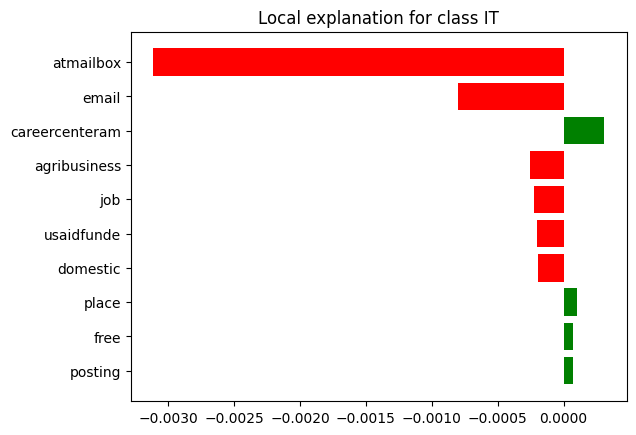

In [178]:
# Function to predict probabilities for text instances
def predict_proba(texts):
    # Convert texts to sequences and pad them to the same length as used in training
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
    # Use the RNN to predict the probabilities
    return rnn_model.predict(padded_sequences)

# Create a LimeTextExplainer
explainer = LimeTextExplainer(class_names=['Non-IT', 'IT'])

idx = 42  # Example index
text_instance = jobs_with_labels['Jobpost'].iloc[idx]  # Selecting the job post at the given index

# Generate an explanation with at most 10 features
exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)

# Show the explanation
print(exp.as_list())
exp.as_pyplot_figure()
plt.show()

In [188]:
rnn_model.save("rnn_model.h5")
print("Model saved successfully.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


# Similarity of Job Titles

In [179]:
# Import the cosine_similarity function from the sklearn.metrics.pairwise module
from sklearn.metrics.pairwise import cosine_similarity

# Define a function to calculate cosine similarity
def get_cosine_sim(doc):
    # Get vectors for each document
    vectors = [t for t in get_vectors(doc)]
    # Calculate cosine similarity between vectors
    return cosine_similarity(vectors)

# Define a function to get vectors from documents
def get_vectors(doc):
    # Convert documents into a list of strings
    text = [t for t in doc]
    # Initialize CountVectorizer with the document text
    vectorizer = CountVectorizer(text)
    # Fit the vectorizer on the text and transform it into a document-term matrix
    vectorizer.fit(text)
    # Return the document-term matrix as an array
    return vectorizer.transform(text).toarray()

In [180]:
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

In [181]:
jobpost_preprocessed.head(5)

,Jobpost,Title
0,ameria investment consult company job title ch...,chief financial officer
1,international research exchange board irex tit...,fulltime community connection intern pay inter...
2,caucasus environmental ngo network cenn job ti...,country coordinator
3,manoff group job title bcc specialist position...,bcc specialist
4,yerevan brandy company job title software deve...,software developer


In [182]:
# Initialize an empty list to store TaggedDocument objects
docs = []

# Define a function to tag documents
def fn_tag_doc(jobpost, title):
    # Split the jobpost into words and create a TaggedDocument object with the words as the 'words' attribute
    # and the title as the 'tags' attribute
    docs.append(TaggedDocument(words=jobpost.split(), tags=[title]))

# Apply the fn_tag_doc function to each row of the DataFrame df_sim
jobpost_preprocessed.apply(lambda x: fn_tag_doc(x['Jobpost'], x['Title']), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
18996    None
18997    None
18998    None
18999    None
19000    None
Length: 18865, dtype: object

In [183]:
docs[1]

TaggedDocument(words=['international', 'research', 'exchange', 'board', 'irex', 'title', 'fulltime', 'community', 'connection', 'intern', 'pay', 'internship', 'duration', 'month', 'location', 'irex', 'armenia', 'main', 'office', 'yerevan', 'armenia', 'description', 'irex', 'currently', 'seek', 'fill', 'position', 'pay', 'intern', 'community', 'connection', 'cc', 'program', 'position', 'base', 'yerevan', 'office', 'applicant', 'willing', 'travel', 'armenia', 'necessary', 'position', 'report', 'directly', 'cc', 'program', 'manager', 'responsibility', 'present', 'cc', 'program', 'interested', 'party', 'assist', 'planning', 'scheduling', 'programmatic', 'meeting', 'event', 'include', 'coordinate', 'logistic', 'cc', 'staff', 'visitor', 'participant', 'assist', 'program', 'staff', 'translationinterpretation', 'armenian', 'english', 'vice', 'versa', 'help', 'create', 'maintain', 'update', 'cc', 'filing', 'system', 'database', 'complete', 'general', 'administrative', 'task', 'cc', 'program', '

Build a Model to convert each document(jobpost) into vectors to be used to check similarity

In [184]:
model_sim = Doc2Vec(docs, dm=0, alpha = 0.025, min_alpha = 0.025, min_count = 0)

In [185]:
# Iterate over 10 epochs
for epoch in range(10):
    # Train the doc2vec model using the provided documents, updating the model parameters
    model_sim.train(docs, total_examples=model_sim.corpus_count, epochs=model_sim.epochs)
    # Decrease the learning rate by 0.002
    model_sim.alpha -= 0.002
    # Fix the learning rate, preventing further decay
    model_sim.min_alpha = model_sim.alpha

In [186]:
# Show top 10 titles which are similar to the title 'data analyst'.
result = model_sim.docvecs.most_similar(positive=[model_sim.infer_vector('data analyst'.split())],topn=10)

# Create a DataFrame named 'similarity' containing the similarity scores and corresponding job titles
similarity = pd.DataFrame(result, columns=['Job Title', 'Similarity Score'])

similarity.head(10)

<ipython-input-186-0e04c3c948f2>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  result = model_sim.docvecs.most_similar(positive=[model_sim.infer_vector('data analyst'.split())],topn=10)


,Job Title,Similarity Score
0,system analyst,0.549517
1,fraud revenue assurance analyst,0.543620
2,fraud revenue assurance analyst developer,0.542717
3,data analyst,0.540765
4,market research analyst,0.540132
5,software architect,0.531798
6,senior oracle pl sql developer,0.529631
7,business intelligence analyst,0.526930
8,datum scientist,0.524975
9,risk management specialist,0.516208


In [189]:
model_sim.save("similarity_model.model")
print("Model saved successfully.")

Model saved successfully.
